In [ ]:
# Checking the directories
!ls /d/KWS

In [ ]:
!ls /d/KWS/data

In [ ]:
# Extracting the feaures in the feat_librosa folder
#!tar -xvf  '/d/KWS/data/feat_compressed.tar' -C '/d/KWS/data/'

In [ ]:
#!pip install matplotlib

In [3]:
# Importing the required Libraries
import torch
import librosa
import os
import time
from tqdm import tqdm
import numpy as np
import pickle

##### Creating Train and Test Data 

In [20]:
# Creating Training and Testing data
feat_shape = 512
root = 'D:/KWS/data/'
feat_folder = os.path.join(root, 'feat')

lst = sorted(os.listdir(feat_folder))

labels = [d for d in lst if os.path.isdir(os.path.join(feat_folder, d))
          and d[0].isalpha()]

train_samples = [0 for label in labels]
test_samples = [0 for label in labels]

#count train-test first
for i, label in enumerate(labels):
    record_list = sorted(os.listdir(os.path.join(feat_folder, label)))
    for r, record_name in enumerate(record_list):
        if hash(record_name) % 10 < 9:
            train_samples[i] += 1
        else:
            test_samples[i] += 1

for i, label in tqdm(enumerate(labels)):    
    record_list = sorted(os.listdir(os.path.join(feat_folder, label)))
    time_s = time.time()
    train_count = 0
    test_count = 0
    train_data_class = np.full((train_samples[i], 1), i, dtype=np.uint8)
    train_data_in = np.empty((train_samples[i], feat_shape, 100), dtype=np.float32)
    test_data_class = np.full((test_samples[i], 1), i, dtype=np.uint8)
    test_data_in = np.empty((test_samples[i], feat_shape, 100), dtype=np.float32)

    for r, record_name in enumerate(record_list):
        if r < 100:
            time_s = time.time()
            record_pth = os.path.join(feat_folder, label, record_name)

            record = np.squeeze(np.load(record_pth))      
            if hash(record_name) % 10 < 9:
                train_data_in[train_count, :] = record           
                train_count += 1

            else:
                test_data_in[test_count, :] = record
                test_count += 1

 
    if i == 0:

        train_data_in_all = train_data_in.copy()
        train_data_class_all = train_data_class.copy()
        test_data_in_all = test_data_in.copy()
        test_data_class_all = test_data_class.copy()
    else:

        train_data_in_all = np.concatenate((train_data_in_all, train_data_in), axis=0)
        train_data_class_all = np.concatenate((train_data_class_all, train_data_class), axis=0)    
        test_data_in_all = np.concatenate((test_data_in_all, test_data_in), axis=0)
        test_data_class_all = np.concatenate((test_data_class_all, test_data_class), axis=0)  

    dur = time.time() - time_s
    if i == 9: #THIS WAS INTENTIONALLY CUT SHORT FOR THE SAKE OF SPPED IN POC BUILDING
        break
print(train_data_in_all.shape)
print(test_data_in_all.shape)
print('done')

9it [00:38,  4.33s/it]

(22180, 512, 100)
(2613, 512, 100)
done


In [23]:
train_data = []
for i in range(len(train_data_in_all)):
    train_data.append([train_data_in_all[i], train_data_class_all[i]])

# with open("D:/KWS/data/train_data.txt", "wb") as fp:   #Pickling
#     pickle.dump(train_data, fp)

In [22]:
test_data = []
for i in range(len(test_data_in_all)):
    test_data.append([test_data_in_all[i], test_data_class_all[i]])

# with open("D:/KWS/data/test_data.txt", "wb") as fp:   #Pickling
#     pickle.dump(test_data, fp)

In [ ]:
# # Loading the train and test data
# with open("D:/KWS/data/train_data.txt", "rb") as fp:   # Unpickling
#     train_data = pickle.load(fp)
    
# with open("D:/KWS/data/test_data.txt", "rb") as fp:   # Unpickling
#     test_data = pickle.load(fp)

In [24]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [14]:
#!nvidia-smi

In [25]:
number_classes = len(np.unique(train_data_class_all))
number_classes

10

C:\Users\kws\AppData\Local\Temp/ipykernel_12380/4235244995.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = T.tensor(batch_data).to(self.device, dtype=torch.float )


Finish epoch  0 total loss 787.434 accuracy 0.163
Finish epoch  1 total loss 772.188 accuracy 0.172
Finish epoch  2 total loss 763.502 accuracy 0.171
Finish epoch  3 total loss 758.450 accuracy 0.180
Finish epoch  4 total loss 756.558 accuracy 0.187
Finish epoch  5 total loss 752.393 accuracy 0.188
Finish epoch  6 total loss 751.798 accuracy 0.190
Finish epoch  7 total loss 750.290 accuracy 0.189
Finish epoch  8 total loss 749.808 accuracy 0.191
Finish epoch  9 total loss 748.883 accuracy 0.193


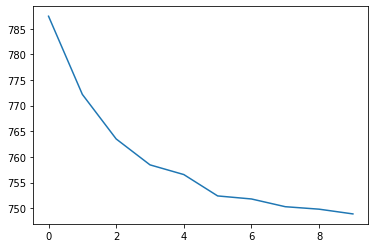

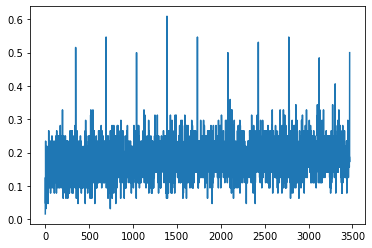

total loss 88.354 accuracy 0.198


In [26]:
class CNN(nn.Module):
    def __init__(self, lr, epochs, batch_size, num_classes= number_classes):
        super(CNN, self).__init__()
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.loss_history = []
        self.acc_history = []
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        self.conv1 = nn.Conv1d(512, 128, 9)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 128, 9)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 96, 9)
        self.bn3 = nn.BatchNorm1d(96)
        
        self.maxpool1 = nn.MaxPool1d(2)
        
        self.conv4 = nn.Conv1d(96, 64, 3)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.maxpool2 = nn.MaxPool1d(2)

        input_dims = self.calc_input_dims()

        self.fc1 = nn.Linear(input_dims, self.num_classes)

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

        self.loss = nn.CrossEntropyLoss()
        self.to(self.device)
        self.get_data()

    def calc_input_dims(self):
        batch_data = T.zeros((1, 512, 100))
        batch_data = self.conv1(batch_data)
        #batch_data = self.bn1(batch_data)
        batch_data = self.conv2(batch_data)
        #batch_data = self.bn2(batch_data)
        batch_data = self.conv3(batch_data)

        batch_data = self.maxpool1(batch_data)
        batch_data = self.conv4(batch_data)
        batch_data = self.maxpool2(batch_data)

        return int(np.prod(batch_data.size()))

    def forward(self, batch_data):
        batch_data = T.tensor(batch_data).to(self.device, dtype=torch.float )

        batch_data = self.conv1(batch_data)
        batch_data = self.bn1(batch_data)
        batch_data = F.relu(batch_data)

        batch_data = self.conv2(batch_data)
        batch_data = self.bn2(batch_data)
        batch_data = F.relu(batch_data)

        batch_data = self.conv3(batch_data)
        batch_data = self.bn3(batch_data)
        batch_data = F.relu(batch_data)

        batch_data = self.maxpool1(batch_data)

        batch_data = self.conv4(batch_data)
        batch_data = self.bn4(batch_data)
        batch_data = F.relu(batch_data)

        batch_data = self.maxpool2(batch_data)

        batch_data = batch_data.view(batch_data.size()[0], -1)

        classes = self.fc1(batch_data)

        return classes


    def get_data(self):
        self.train_data_loader = T.utils.data.DataLoader(train_data,
                                                    batch_size=self.batch_size,
                                                    shuffle=True,
                                                    num_workers=8)

        self.test_data_loader = T.utils.data.DataLoader(test_data,
                                                    batch_size=self.batch_size,
                                                    shuffle=True,
                                                    num_workers=8)

    def _train(self):
        self.train()
        for i in range(self.epochs):
            ep_loss = 0
            ep_acc = []
            for j, (input, label) in enumerate(self.train_data_loader):
                self.optimizer.zero_grad()
                label = label.to(self.device)            
                prediction = self.forward(input)                
                loss = self.loss(prediction, label.flatten().to(self.device))
                prediction = F.softmax(prediction, dim=1)
                
                classes = T.argmax(prediction, dim=1)
                
                wrong = T.where(classes != label.flatten().to(self.device),
                                T.tensor([1.]).to(self.device, dtype=torch.float),
                                T.tensor([0.]).to(self.device, dtype=torch.float))
                
                acc = 1 - T.sum(wrong) / self.batch_size

                ep_acc.append(acc.item())
                self.acc_history.append(acc.item())
                ep_loss += loss.item()
                loss.backward()
                self.optimizer.step()
            print('Finish epoch ', i, 'total loss %.3f' % ep_loss,
                    'accuracy %.3f' % np.mean(ep_acc))
            self.loss_history.append(ep_loss)

    def _test(self):
        self.eval()

        ep_loss = 0
        ep_acc = []
        for j, (input, label) in enumerate(self.test_data_loader):
            label = label.to(self.device)          
            prediction = self.forward(input)                
            loss = self.loss(prediction, label.flatten().to(self.device))
            prediction = F.softmax(prediction, dim=1)
            classes = T.argmax(prediction, dim=1)
            wrong = T.where(classes != label.flatten().to(self.device),
                            T.tensor([1.]).to(self.device, dtype=torch.float),
                            T.tensor([0.]).to(self.device, dtype=torch.float))
            acc = 1 - T.sum(wrong) / self.batch_size

            ep_acc.append(acc.item())

            ep_loss += loss.item()

        print('total loss %.3f' % ep_loss,
                'accuracy %.3f' % np.mean(ep_acc))

# Running the model
if __name__ == '__main__':
    network = CNN(lr=0.001, batch_size=64, epochs= 10)
    network._train()
    plt.plot(network.loss_history)
    plt.show()
    plt.plot(network.acc_history)
    plt.show()
    network._test()

In [33]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in network.state_dict():
    print(param_tensor, "\t", network.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in network.optimizer.state_dict():
    print(var_name, "\t", network.optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([128, 512, 9])
conv1.bias 	 torch.Size([128])
bn1.weight 	 torch.Size([128])
bn1.bias 	 torch.Size([128])
bn1.running_mean 	 torch.Size([128])
bn1.running_var 	 torch.Size([128])
bn1.num_batches_tracked 	 torch.Size([])
conv2.weight 	 torch.Size([128, 128, 9])
conv2.bias 	 torch.Size([128])
bn2.weight 	 torch.Size([128])
bn2.bias 	 torch.Size([128])
bn2.running_mean 	 torch.Size([128])
bn2.running_var 	 torch.Size([128])
bn2.num_batches_tracked 	 torch.Size([])
conv3.weight 	 torch.Size([96, 128, 9])
conv3.bias 	 torch.Size([96])
bn3.weight 	 torch.Size([96])
bn3.bias 	 torch.Size([96])
bn3.running_mean 	 torch.Size([96])
bn3.running_var 	 torch.Size([96])
bn3.num_batches_tracked 	 torch.Size([])
conv4.weight 	 torch.Size([64, 96, 3])
conv4.bias 	 torch.Size([64])
bn4.weight 	 torch.Size([64])
bn4.bias 	 torch.Size([64])
bn4.running_mean 	 torch.Size([64])
bn4.running_var 	 torch.Size([64])
bn4.num_batches_tracked 	 torch.Size([])
fc1.weigh

In [34]:
PATH = 'C:/Users/kws/Documents/CNN1/CNN1_weights.pth'
torch.save(network.state_dict(), PATH)

In [38]:
model = torch.load('C:/Users/kws/Documents/CNN1/CNN1_weights.pth')